<a href="https://colab.research.google.com/github/timkhsm/Classifier/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 60

Autosaving every 60 seconds


In [ ]:
import os
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import json
import pickle
from pathlib import Path
from typing import Any, Dict
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

#откуда распаковка
zip_path = '/content/drive/MyDrive/files_ml/files_ml.zip'

#куда распаковка
extract_path = '/content/drive/MyDrive/files_ml/unzipped_data'

#распаковка
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Внутри: \n")
print(os.listdir(extract_path))

Внутри: 

['files_ml', '__MACOSX']


# Итотовая работа по ML
- Подробности на странице на платформе
- Данные для этой работы - это датасет с бинарной целевой переменной. Данные доступны по ссылке на платформе.


Вот описание данных:

**Данные по оттоку клиентов**
- client_id - уникальный id клиента
- регион - локация клиента
- использование - использование мобильной связи
- сумма - сумма пополнения баланса
- частота_пополнения - сколько раз клиент пополнял аккаунт
- доход - доход с одного клиента в месяц
- сегмент_arpu - выручка за квартал
- частота - сколько раз клиент приносил прибыль
- объем_данных - число раз, когда клиент делал подключение
- on_net - число звонков внутри сети
- продукт_1 - тариф 1
- продукт_2 - тариф 2
- зона_1 - звонки из гео-области 1
- зона_2 - звонки из гео-области 2
- mrg_ - флаг
- секретный_скор - некоторый модельный скор клиента
- pack - самый активный пакет клиента
- pack_freq - частота активации пакета pack
- binary_target - флаг оттока клиента

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/files_ml/unzipped_data/files_ml/train.csv"
TEST_PATH  = "/content/drive/MyDrive/files_ml/unzipped_data/files_ml/test_full.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("train shape:", train.shape)
print("test  shape:", test.shape)
train.head()

train shape: (1010248, 19)
test  shape: (497586, 19)


,client_id,регион,использование,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,mrg_,секретный_скор,pack,pack_freq,binary_target
0,0,Уран,>24LY,14.617797,1.0,27034.974914,71.37,1.000000,NaN,26.0,10.0,NaN,NaN,NaN,False,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1,1,Марс,>24LY,32.686083,3.0,40373.828300,354.27,2.000000,35.679126,45.0,8.0,NaN,NaN,NaN,False,0.573770,тариф_a 250 (условие) _безлим_c_output_сутки,1.414214,0
2,2,Церера,>24LY,25.318570,3.0,32004.378374,139.74,1.414214,NaN,NaN,13.0,NaN,NaN,NaN,False,0.131148,NaN,NaN,0
3,3,Марс,>24LY,70.710678,38.0,59953.505011,1722.65,6.403124,163.309522,203.0,274.0,NaN,NaN,0.031817,False,0.885246,"трафик: 100 (условие) 40mb,_сутки",4.000000,0
4,4,Меркурий,>24LY,9.244999,2.0,21499.998428,28.63,1.414214,5.000000,NaN,NaN,NaN,NaN,NaN,False,0.344262,"трафик: 100 (условие) 40mb,_сутки",1.000000,0


## Место для вашего кода ↓↓↓

## Обучение модели / написание вспомогательно кода ↓↓↓

In [ ]:
# Функция очистки признаков перед созданием новых фич
def safe_numeric_convert(df, columns):
    for col in columns:
        # Попытка конвертации в numeric, с заменой некорректных значений на NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Обновляем блок с feature engineering
num_cols_orig = [
    "использование",
    "сумма",
    "частота_пополнения",
    "доход",
    "сегмент_arpu",
    "частота",
    "объем_данных",
    "on_net",
    "зона_1",
    "зона_2",
    "mrg_",
    "секретный_скор",
    "pack_freq",
]

# Безопасная конвертация
train = safe_numeric_convert(train, num_cols_orig)

# Создание новых признаков
train["arpu_per_topup"] = train["доход"] / (train["частота_пополнения"] + 1)
train["usage_per_data"] = train["использование"] / (train["объем_данных"] + 1)

# Обновляем список признаков
num_cols = num_cols_orig + ["arpu_per_topup", "usage_per_data"]

# Проверка конвертации
print(train[num_cols].dtypes)

использование         float64
сумма                 float64
частота_пополнения    float64
доход                 float64
сегмент_arpu          float64
частота               float64
объем_данных          float64
on_net                float64
зона_1                float64
зона_2                float64
mrg_                     bool
секретный_скор        float64
pack_freq             float64
arpu_per_topup        float64
usage_per_data        float64
dtype: object


In [ ]:
cat_pipe = Pipeline(
    [
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ]
)

In [ ]:
# ====================================================
# 1. Разметка признаков
# ====================================================
ID_COL = "client_id"
TARGET_COL = "binary_target"

cat_cols = [
    "регион",
    "продукт_1",
    "продукт_2",
    "pack",
]
num_cols = [
    "использование",
    "сумма",
    "частота_пополнения",
    "доход",
    "сегмент_arpu",
    "частота",
    "объем_данных",
    "on_net",
    "зона_1",
    "зона_2",
    "mrg_",
    "секретный_скор",
    "pack_freq",
]

# Безопасное создание новых признаков
def safe_feature_engineering(df):
    df = df.copy()
    # Конвертируем в numeric
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Создаем новые признаки
    df["arpu_per_topup"] = df["доход"] / (df["частота_пополнения"] + 1)
    df["usage_per_data"] = df["использование"] / (df["объем_данных"] + 1)
    return df

train = safe_feature_engineering(train)
num_cols += ["arpu_per_topup", "usage_per_data"]

# ====================================================
# 2. Пайплайн
# ====================================================
num_pipe = Pipeline(
    [("imp", SimpleImputer(strategy="median")),
     ("sc", StandardScaler())]
)

cat_pipe = Pipeline(
    [("imp", SimpleImputer(strategy="most_frequent")),
     ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]  # ← ИСПРАВЛЕНО!
)

preproc = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)],
    remainder="drop",
)

lgbm = LGBMClassifier(
    n_estimators=450,
    max_depth=6,
    learning_rate=0.06,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

pipe = Pipeline([("prep", preproc), ("lgbm", lgbm)])


# ====================================================
# 3. Валидация (5-fold CV по F1)
# ====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train.drop([TARGET_COL], axis=1)
y = train[TARGET_COL].values

cv_scores = []
for tr_idx, val_idx in cv.split(X, y):
    pipe.fit(X.iloc[tr_idx], y[tr_idx])
    preds = pipe.predict(X.iloc[val_idx])
    cv_scores.append(f1_score(y[val_idx], preds))

print(f"5-fold CV F1: {np.mean(cv_scores):.4f}  (+/- {np.std(cv_scores):.4f})")


# ====================================================
# 4. Финальное обучение на всём train
# ====================================================
pipe.fit(X, y)

# Подберём оптимальный порог
probas = pipe.predict_proba(X)[:, 1]
thr_candidates = np.linspace(0.3, 0.7, 41)
best_thr, best_f1 = 0.5, 0
for thr in thr_candidates:
    f1 = f1_score(y, (probas >= thr).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"Chosen threshold {best_thr:.2f}  (train F1={best_f1:.4f})")


# ====================================================
# 5. Сериализация
# ====================================================
Path("artifacts").mkdir(exist_ok=True)

with open("artifacts/model.pkl", "wb") as f:
    pickle.dump(pipe, f)

meta = {
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "threshold": best_thr,
}
with open("artifacts/meta.json", "w", encoding="utf8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)


# ====================================================
# 6. Production-функция для проверки (QoS <0.10 ms)
# ====================================================
with open("artifacts/model.pkl", "rb") as f:
    _MODEL = pickle.load(f)
with open("artifacts/meta.json", encoding="utf8") as f:
    _META = json.load(f)

_NUM = _META["num_cols"]
_CAT = _META["cat_cols"]
_THR = _META["threshold"]


def _dict2df(d: Dict[str, Any]) -> pd.DataFrame:
    """Быстрая конвертация одного клиента в DataFrame нужных столбцов."""
    # Добавляем feature engineering
    d = d.copy()

    # Конвертируем в числа
    for col in _NUM:
        if col in d:
            try:
                d[col] = float(d[col]) if d[col] is not None else np.nan
            except:
                d[col] = np.nan

    # Создаём новые признаки
    if "доход" in d and "частота_пополнения" in d:
        d["arpu_per_topup"] = d["доход"] / (d["частота_пополнения"] + 1)
    if "использование" in d and "объем_данных" in d:
        d["usage_per_data"] = d["использование"] / (d["объем_данных"] + 1)

    # заполняем отсутствующие ключи NaN'ами
    all_keys = {**{c: np.nan for c in _NUM + _CAT + [ID_COL]}, **d}
    return pd.DataFrame([all_keys], columns=_NUM + _CAT + [ID_COL])


def get_score(dict_input: Dict[str, Any]) -> Dict[str, int]:
    """
    Production-скоринг. Отдаёт prediction 0/1.
    dict_input — один клиент (ключ-значение).
    """
    df_one = _dict2df(dict_input)
    proba = _MODEL.predict_proba(df_one)[:, 1][0]
    pred = int(proba >= _THR)
    return {"client_id": dict_input["client_id"], "prediction": pred}


# ====================================================
# 7. Быстрый самотест latency
# ====================================================
sample_req = train.iloc[0].drop(TARGET_COL).to_dict()

N_RUNS = 10000
t0 = time.perf_counter_ns()
for _ in range(N_RUNS):
    get_score(sample_req)
lat_ms = (time.perf_counter_ns() - t0) / 1e6 / N_RUNS
print(f"Mean latency = {lat_ms:.4f} ms  (reqs: {N_RUNS})")

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 151428, number of negative: 656770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4763
[LightGBM] [Info] Number of data points in the train set: 808198, number of used features: 1257
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187365 -> initscore=-1.467224
[LightGBM] [Info] Start training from score -1.467224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 151428, number of negative: 656770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4781
[LightGBM] [Info] Number of data points in the train set: 808198, number of used features: 1268
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187365 -> initscore=-1.467224
[LightGBM] [Info] Start training from score -1.467224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 151428, number of negative: 656770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 808198, number of used features: 1287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187365 -> initscore=-1.467224
[LightGBM] [Info] Start training from score -1.467224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 151428, number of negative: 656771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.457684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4686
[LightGBM] [Info] Number of data points in the train set: 808199, number of used features: 1254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187365 -> initscore=-1.467225
[LightGBM] [Info] Start training from score -1.467225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 151428, number of negative: 656771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4713
[LightGBM] [Info] Number of data points in the train set: 808199, number of used features: 1271
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187365 -> initscore=-1.467225
[LightGBM] [Info] Start training from score -1.467225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


5-fold CV F1: 0.6061  (+/- 0.0016)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 189285, number of negative: 820963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.354646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4980
[LightGBM] [Info] Number of data points in the train set: 1010248, number of used features: 1397
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187365 -> initscore=-1.467224
[LightGBM] [Info] Start training from score -1.467224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Chosen threshold 0.33  (train F1=0.6538)


Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Mean latency = 26.4545 ms  (reqs: 10000)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skip

## код логики production функции ↓↓↓
У нас маленькая компания, поэтому есть ограничения на вычислительные ресурсы. __Ограничение на число CPU в модели внутри функции def get_score - 1 ядро, это означает что нужно ставить следующие параметры (модель должна работать на одном CPU)__
Если вы обучались на нескольких ядрах CPU (или даже GPU) - поменяйте параметры в уже обученной модели, чтобы в production она использовала только одно ядро

- это нужно явно показать в коде
- для уже обученных моделей:
- для catboost - model.predict(thread_count=1)
- для lightgbm - model.set_params(n_jobs=1) и затем model.get_params().get('n_jobs')
- для xgboost - model.set_params(n_jobs=1) и затем model.get_params()['n_jobs']
- для других классификаторов смотрите документацию



In [ ]:
import json, pickle, numpy as np, pandas as pd

ID_COL = "client_id"

with open("artifacts/model.pkl", "rb") as f:
    _MODEL = pickle.load(f)

with open("artifacts/meta.json", encoding="utf8") as f:
    _META = json.load(f)

_NUM = _META["num_cols"]
_CAT = _META["cat_cols"]
_THR = _META["threshold"]

# ─────────────────────────────────────────────────────────────
# 1. Ограничиваем модель одним ядром
# ─────────────────────────────────────────────────────────────
_MODEL.named_steps["lgbm"].set_params(n_jobs=1)
assert _MODEL.named_steps["lgbm"].get_params()["n_jobs"] == 1

# ─────────────────────────────────────────────────────────────
# 2. Вспомогательная функция с защитой от деления на 0
# ─────────────────────────────────────────────────────────────
def _dict2df(d: dict) -> pd.DataFrame:
    d = d.copy()

    # безопасное приведение числовых полей к float
    for col in _NUM:
        if col in d:
            try:
                d[col] = float(d[col]) if d[col] not in ("", None) else np.nan
            except Exception:
                d[col] = np.nan

    # runtime-feature engineering с защитой
    topup = d.get("частота_пополнения", 0)
    d["arpu_per_topup"] = (
        d.get("доход", np.nan) / (topup + 1)
    )

    usage = d.get("использование", np.nan)
    data_volume = d.get("объем_данных", 0)

    if data_volume + 1 == 0:
        d["usage_per_data"] = np.nan  # безопасное значение
    else:
        d["usage_per_data"] = usage / (data_volume + 1)

    all_cols = _NUM + _CAT + [ID_COL]
    filled = {**{c: np.nan for c in all_cols}, **d}  # гарантируем полный набор колонок
    return pd.DataFrame([filled], columns=all_cols)

# ─────────────────────────────────────────────────────────────
# 3. Production-функция
# ─────────────────────────────────────────────────────────────
def get_score(dict_input: dict):
    df_one = _dict2df(dict_input)
    proba = _MODEL.predict_proba(df_one)[:, 1][0]
    binary = int(proba >= _THR)
    return {"client_id": dict_input["client_id"], "prediction": binary}

# ─────────────────────────────────────────────────────────────
# 4. Параллельная версия (если нужно)
# ─────────────────────────────────────────────────────────────
from concurrent.futures import ThreadPoolExecutor

def get_scores_parallel(list_of_dicts, max_workers=8):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(get_score, list_of_dicts))
    return results

In [ ]:
pip install -q line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 10.7 MB/s eta 0:00:00


In [ ]:
from line_profiler import LineProfiler

# Один клиент
row_input = test.sample(1, random_state=0).to_dict(orient="records")[0]

lp = LineProfiler()
lp_wrapper = lp(get_score)
_ = lp_wrapper(row_input)
lp.print_stats(output_unit=1e-6)

# Параллельная партия
list_of_dicts = test.sample(100, random_state=0).to_dict(orient="records")

lp_parallel = LineProfiler()
lp_wrapper_parallel = lp_parallel(get_scores_parallel)
_ = lp_wrapper_parallel(list_of_dicts)
lp_parallel.print_stats(output_unit=1e-6)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skip

Timer unit: 1e-06 s

Total time: 0.0445576 s

Could not find file /tmp/ipython-input-12-3071810112.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
    56                                           
    57         1       1716.5   1716.5      3.9  
    58         1      42833.4  42833.4     96.1  
    59         1          6.5      6.5      0.0  
    60         1          1.2      1.2      0.0  



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skip

Timer unit: 1e-06 s

Total time: 2.76031 s

Could not find file /tmp/ipython-input-12-3071810112.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
    67                                           
    68         2      10244.8   5122.4      0.4  
    69         1    2750062.9    3e+06     99.6  
    70         1          0.5      0.5      0.0  



______
## Тут нужно написать код для пятого пункта дз ↓↓↓

*проверка качества предсказания модели (без знания о целевой переменной, только на основе входных данных и выходного предсказания)*

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


TRAIN  positive-rate = 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


BATCH version done!
TEST   positive-rate = 0.242
PSI = 0.0000   |   KS = 0.0014


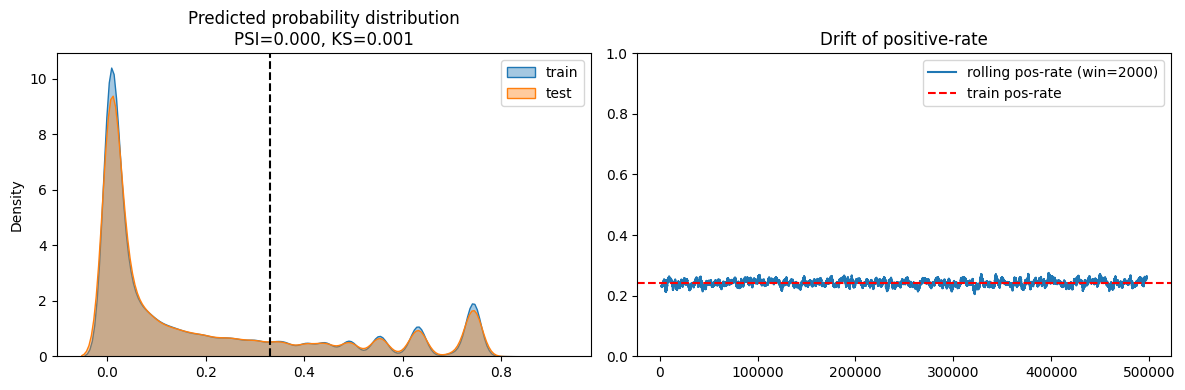

In [ ]:
import warnings
from scipy.stats import ks_2samp
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

# ============================================================
# 1. TRAIN — теперь с runtime-фичами и приведением типов
# ============================================================

X_train = train.drop(columns=["binary_target"]).copy()

# Приводим ключевые колонки к числу, чтобы избежать 'str'
for col in ["доход", "частота_пополнения", "использование", "объем_данных"]:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")

# Добавляем runtime-фичи
X_train["arpu_per_topup"] = X_train["доход"] / (X_train["частота_пополнения"] + 1)
X_train["usage_per_data"] = X_train["использование"] / (X_train["объем_данных"] + 1)

train_proba = _MODEL.predict_proba(X_train)[:, 1]
train_pos_rate = (train_proba >= _THR).mean()
print(f"TRAIN  positive-rate = {train_pos_rate:.3f}")

# ============================================================
# 2. TEST — три версии с флагами
# ============================================================

DO_BATCH = True
DO_PARALLEL = False
DO_SLOW = False

if DO_BATCH:
    X_test = test.drop(columns=["binary_target"]).copy()

    # Приводим ключевые колонки к числу
    for col in ["доход", "частота_пополнения", "использование", "объем_данных"]:
        X_test[col] = pd.to_numeric(X_test[col], errors="coerce")

    # Добавляем runtime-фичи
    X_test["arpu_per_topup"] = X_test["доход"] / (X_test["частота_пополнения"] + 1)
    X_test["usage_per_data"] = X_test["использование"] / (X_test["объем_данных"] + 1)

    test_proba_batch = _MODEL.predict_proba(X_test)[:, 1]
    preds_bin_batch = (test_proba_batch >= _THR).astype(int)
    print(f"BATCH version done!")

if DO_PARALLEL:
    list_of_dicts = test.to_dict(orient="records")
    results_parallel = get_scores_parallel(list_of_dicts)
    preds_bin_parallel = np.array([r["prediction"] for r in results_parallel])

    # Если внутри get_score не возвращаешь вероятности, можно взять из batch
    test_proba_parallel = test_proba_batch
    print(f"PARALLEL get_score version done!")

if DO_SLOW:
    preds_bin_slow = []
    test_proba_slow = []

    for row in tqdm(test.itertuples(index=False), total=len(test)):
        d = {
            "client_id":          row.client_id,
            "регион":             row.регион,
            "использование":      row.использование,
            "сумма":              row.сумма,
            "частота_пополнения": row.частота_пополнения,
            "доход":              row.доход,
            "сегмент_arpu":       row.сегмент_arpu,
            "частота":            row.частота,
            "объем_данных":       row.объем_данных,
            "on_net":             row.on_net,
            "продукт_1":          row.продукт_1,
            "продукт_2":          row.продукт_2,
            "зона_1":             row.зона_1,
            "зона_2":             row.зона_2,
            "mrg_":               row.mrg_,
            "секретный_скор":     row.секретный_скор,
            "pack":               row.pack,
            "pack_freq":          row.pack_freq,
        }
        preds_bin_slow.append(get_score(d)["prediction"])
        df_one = _dict2df(d)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            proba = _MODEL.predict_proba(df_one)[:, 1][0]
        test_proba_slow.append(proba)

    preds_bin_slow = np.asarray(preds_bin_slow)
    test_proba_slow = np.asarray(test_proba_slow)
    print(f"SLOW get_score version done!")

# ============================================================
# 3. Явный выбор версий — что использовать дальше
# ============================================================

if DO_BATCH:
    test_proba = test_proba_batch
    preds_bin  = preds_bin_batch
elif DO_PARALLEL:
    test_proba = test_proba_parallel
    preds_bin  = preds_bin_parallel
elif DO_SLOW:
    test_proba = test_proba_slow
    preds_bin  = preds_bin_slow

test_pos_rate = (test_proba >= _THR).mean()
print(f"TEST   positive-rate = {test_pos_rate:.3f}")

# ============================================================
# 4. PSI + KS
# ============================================================

def psi(expected, actual, n_bins: int = 10) -> float:
    quantiles = np.quantile(expected, np.linspace(0, 1, n_bins + 1))
    quantiles[0] -= 1e-6
    exp_cnt, _ = np.histogram(expected, bins=quantiles)
    act_cnt, _ = np.histogram(actual, bins=quantiles)
    exp_pct = exp_cnt / exp_cnt.sum()
    act_pct = act_cnt / act_cnt.sum()
    return np.sum((act_pct - exp_pct) * np.log((act_pct + 1e-9) / (exp_pct + 1e-9)))

psi_val = psi(train_proba, test_proba)
ks_val  = ks_2samp(train_proba, test_proba).statistic
print(f"PSI = {psi_val:.4f}   |   KS = {ks_val:.4f}")

# ============================================================
# 5. Визуализация
# ============================================================

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(train_proba, label="train", fill=True, alpha=.4)
sns.kdeplot(test_proba,  label="test",  fill=True, alpha=.4)
plt.axvline(_THR, color="k", ls="--")
plt.title(f"Predicted probability distribution\nPSI={psi_val:.3f}, KS={ks_val:.3f}")
plt.legend()

plt.subplot(1, 2, 2)
window = 2000
pd.Series(preds_bin).rolling(window).mean().plot(label=f"rolling pos-rate (win={window})")
plt.axhline(train_pos_rate, color="r", ls="--", label="train pos-rate")
plt.ylim(0, 1)
plt.title("Drift of positive-rate")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# место для вашего кода

## Место для вашего кода ↑↑↑
_______

## Автоматические проверки работы ↓↓↓
### Этот код менять нельзя, иначе проверки в ноутбуке могут сломаться

## тест 1: проверка input модели (1)

In [ ]:
row_input = {
    'client_id': 1010348,
    'регион': 'Нептун',
    'использование': '>24LY',
    'сумма': 31.69021931132696,
    'частота_пополнения': 16.0,
    'доход': 42653.164535362455,
    'сегмент_arpu': 441.45,
    'частота': 4.242640687119285,
    'объем_данных': 32.01562118716424,
    'on_net': np.nan,
    'продукт_1': 12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': False,
    'секретный_скор': 0.6065573770491803,
    'pack': 'трафик: 100 (условие) 40mb,_сутки',
    'pack_freq': 3.0,
    'binary_target': 0
}

In [ ]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


{'client_id': 1010348, 'prediction': 0}

## тест 2: проверка input модели (2)

In [ ]:
row_input = {
    'client_id': -999,
    'регион': 'Калифорния',
    'использование': '<2года',
    'сумма': -999,
    'частота_пополнения': -16.0,
    'доход': -42653.164535362455,
    'сегмент_arpu': -441.45,
    'частота': 0.1,
    'объем_данных': -1,
    'on_net': np.nan,
    'продукт_1': -12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': -0.6065573770491803,
    'pack': 'трафик Тройное условие 123',
    'pack_freq': -3.0,
    'binary_target': -0.1
}

In [ ]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


{'client_id': -999, 'prediction': 1}

## тест 3: проверка output модели

In [ ]:
get_score_result = get_score(row_input)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# если завершилось без ошибок - тест пройден
assert get_score_result['prediction'] in [0, 1]

In [ ]:
# если завершилось без ошибок - тест пройден
assert not bool(set(get_score_result.keys()) - set(['client_id', 'prediction']))

## тест 4: мониторинг времени (1)
- зеленый цвет названия графика означает - что тест пройден
- красный цвет названия графика означает - что тест не пройден

In [ ]:
%%time

# ============================================================
# Выбор версии
# ============================================================

DO_SLOW_FULL = False     # 1) Полный честный цикл (медленно)
DO_BATCH_FULL = False    # 2) Батч на всем датасете (быстро)
DO_SLOW_SAMPLE = True   # 3) Честный цикл на сэмпле (норм)
DO_BATCH_SAMPLE = False   # 4) Батч на сэмпле (максимально быстро)

# ============================================================
# 1) Полный честный цикл (МЕДЛЕННО)
# ============================================================

if DO_SLOW_FULL:

    times = []
    preds = []

    for row in tqdm(test.itertuples(index=False), total=len(test)):
        dict_input_ = {
            "client_id": row.client_id,
            "регион": row.регион,
            "использование": row.использование,
            "сумма": row.сумма,
            "частота_пополнения": row.частота_пополнения,
            "доход": row.доход,
            "сегмент_arpu": row.сегмент_arpu,
            "частота": row.частота,
            "объем_данных": row.объем_данных,
            "on_net": row.on_net,
            "продукт_1": row.продукт_1,
            "продукт_2": row.продукт_2,
            "зона_1": row.зона_1,
            "зона_2": row.зона_2,
            "mrg_": row.mrg_,
            "секретный_скор": row.секретный_скор,
            "pack": row.pack,
            "pack_freq": row.pack_freq,
        }

        stime = time.time()
        score_result = get_score(dict_input_)
        times.append((time.time() - stime))
        preds.append(score_result['prediction'])

    times = np.array(times) * 1000
    print(f"Готово: Полный цикл, предсказаний {len(preds)}")

# ============================================================
# 2) Батч на всем датасете (БЫСТРО)
# ============================================================

if DO_BATCH_FULL:

    print("🚀 BATCH FULL версия")

    X_test = test.drop(columns=["binary_target"]).copy()

    for col in ["доход", "частота_пополнения", "использование", "объем_данных"]:
        X_test[col] = pd.to_numeric(X_test[col], errors="coerce")

    X_test["arpu_per_topup"] = X_test["доход"] / (X_test["частота_пополнения"] + 1)
    X_test["usage_per_data"] = X_test["использование"] / (X_test["объем_данных"] + 1)

    stime = time.time()
    test_proba_batch = _MODEL.predict_proba(X_test)[:, 1]
    elapsed = time.time() - stime

    preds = (test_proba_batch >= _THR).astype(int)
    times = np.full(len(preds), (elapsed / len(preds)) * 1000)

    print(f"BATCH FULL done! {len(preds)} предсказаний")

# ============================================================
# 3) Честный цикл на сэмпле (Нормально)
# ============================================================

if DO_SLOW_SAMPLE:

    sample = test.sample(2000, random_state=0)

    times = []
    preds = []

    for row in tqdm(sample.itertuples(index=False), total=len(sample)):
        dict_input_ = {
            "client_id": row.client_id,
            "регион": row.регион,
            "использование": row.использование,
            "сумма": row.сумма,
            "частота_пополнения": row.частота_пополнения,
            "доход": row.доход,
            "сегмент_arpu": row.сегмент_arpu,
            "частота": row.частота,
            "объем_данных": row.объем_данных,
            "on_net": row.on_net,
            "продукт_1": row.продукт_1,
            "продукт_2": row.продукт_2,
            "зона_1": row.зона_1,
            "зона_2": row.зона_2,
            "mrg_": row.mrg_,
            "секретный_скор": row.секретный_скор,
            "pack": row.pack,
            "pack_freq": row.pack_freq,
        }

        stime = time.time()
        score_result = get_score(dict_input_)
        times.append((time.time() - stime))
        preds.append(score_result['prediction'])

    times = np.array(times) * 1000
    print(f"Готово: Честный сэмпл, предсказаний {len(preds)}")

# ============================================================
# 4) Батч + сэмпл (САМАЯ БЫСТРАЯ)
# ============================================================

if DO_BATCH_SAMPLE:

    print("🚀 BATCH SAMPLE версия")

    sample = test.sample(5000, random_state=0)

    X_sample = sample.drop(columns=["binary_target"]).copy()

    for col in ["доход", "частота_пополнения", "использование", "объем_данных"]:
        X_sample[col] = pd.to_numeric(X_sample[col], errors="coerce")

    X_sample["arpu_per_topup"] = X_sample["доход"] / (X_sample["частота_пополнения"] + 1)
    X_sample["usage_per_data"] = X_sample["использование"] / (X_sample["объем_данных"] + 1)

    stime = time.time()
    test_proba_batch = _MODEL.predict_proba(X_sample)[:, 1]
    elapsed = time.time() - stime

    preds = (test_proba_batch >= _THR).astype(int)
    times = np.full(len(preds), (elapsed / len(preds)) * 1000)

    print(f"BATCH SAMPLE done! {len(preds)} предсказаний")

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/pyt

Готово: Честный сэмпл, предсказаний 2000
CPU times: user 58.6 s, sys: 777 ms, total: 59.4 s
Wall time: 1min 6s


#### Отрисовка оценки времени работы

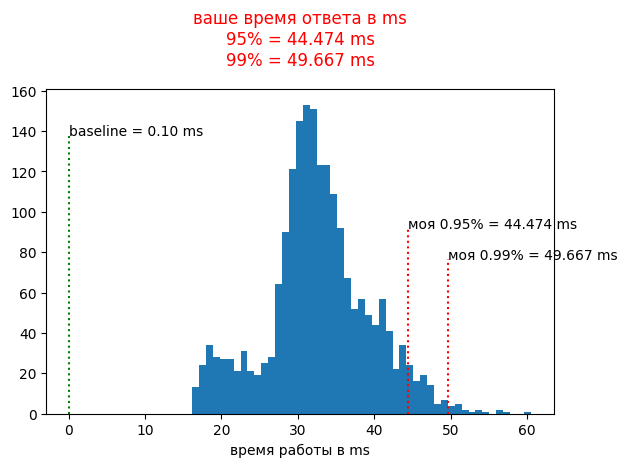

In [ ]:
plt_vals = plt.hist(times, bins=np.linspace(np.quantile(times, 0.001), np.quantile(times, 0.999)))

plt.vlines(0.10, 0, plt_vals[0].max() * 0.9, color='green', linestyle=':')
plt.text(0.10, plt_vals[0].max() * 0.9, s='baseline = 0.10 ms', color='black', rotation=0)

plt.vlines(np.quantile(times, 0.95), 0, plt_vals[0].max() * 0.6, color='red', linestyle=':')
plt.vlines(np.quantile(times, 0.99), 0, plt_vals[0].max() * 0.5, color='red', linestyle=':')

plt.text(
    np.quantile(times, 0.95), plt_vals[0].max() * 0.6,
    s=f'моя 0.95% = {np.quantile(times, 0.95):0.3f} ms', color='black', rotation=0
)
plt.text(
    np.quantile(times, 0.99), plt_vals[0].max() * 0.5,
    s=f'моя 0.99% = {np.quantile(times, 0.99):0.3f} ms', color='black', rotation=0
)

plt.title(
    f'ваше время ответа в ms\n95% = {np.quantile(times, 0.95):0.3f} ms\n99% = {np.quantile(times, 0.99):0.3f} ms',
    y=1.05,
    color=(
        'green'
        if (round(np.quantile(times, 0.95), 3) <= 0.10) & (round(np.quantile(times, 0.99), 3) <= 0.10)
        else 'red'
    )
)

plt.xlabel('время работы в ms')
plt.tight_layout()
plt.show()

In [ ]:
# Тут мы должны увидеть, что модель выдает предсказания быстрее ожидаемого
# Наше предсказание должно быть быстрее baseline в каждом случае

## тест 5: мониторинг времени (2)

In [ ]:
row_input = {
    'client_id': -100,
    'регион': 'Plan_1',
    'использование': '<000',
    'сумма': 0,
    'частота_пополнения': 0.0,
    'доход': np.nan,
    'сегмент_arpu': np.nan,
    'частота': np.nan,
    'объем_данных': np.nan,
    'on_net': np.nan,
    'продукт_1': np.nan,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': 0.0,
    'pack': np.nan,
    'pack_freq': np.nan,
}

In [ ]:
%%timeit
_ = get_score(row_input)

# Ожидаем скорость быстрее 110 µs (<110 µs)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skip

41 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['использование' 'usage_per_data']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skip

## тест 6: мониторинг f1 score
- зеленый цвет названия графика означает, что тест пройден
- красный цвет названия графика означает, что тест не пройден

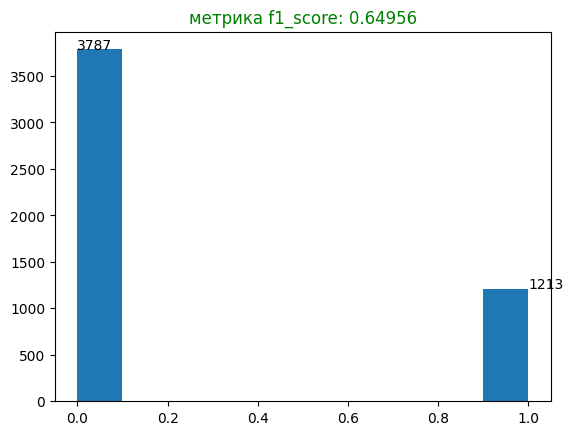

In [ ]:
# ------------------------------------------------------------
# Гарантируем выбор правильного таргета для расчёта F1
# ------------------------------------------------------------
# Если ты используешь сэмпл:
USE_SAMPLE = True   # True — если preds на sample, False — если preds на полном test

# ------------------------------------------------------------
# Гистограмма
# ------------------------------------------------------------
plot_vals = plt.hist(preds)

# ------------------------------------------------------------
# Корректный f1_score
# ------------------------------------------------------------
if USE_SAMPLE:
    true_labels = sample['binary_target']
else:
    true_labels = test['binary_target']

f1 = f1_score(true_labels, preds)

plt.title(
    f"метрика f1_score: {f1:0.5f}",
    color=('red' if f1 < 0.6450 else 'green')
)

plt.text(0, plot_vals[0][0], s=f"{plot_vals[0][0]:0.0f}")
plt.text(1, plot_vals[0][-1], s=f"{plot_vals[0][-1]:0.0f}")

plt.show()

## тест 7: Code Style
- воспользуемся библиотекой для оценки качества кода https://github.com/nbQA-dev/nbQA?tab=readme-ov-file#-examples
- нужно установить актуальную версию pip install flake8
- нужно установить актуальную версию pip install -U nbqa
- в отдельной ячейке нужно выполнить команду: !nbqa flake8 ML_итоговая_шаблон.ipynb (см. эту команду ниже)
- поставьте вместо ML_итоговая_шаблон.ipynb ваше название ноутбука
- запрещается менять эту команду, за исключением названия ноутбука

In [ ]:
os.system("nbqa flake8 --extend-ignore=W291,E501 teta_ML_итоговая_шаблон.ipynb & echo 'everything done'")

0

In [ ]:
# ячейка выше должна отпринтовать следующее
# everything done
# 0

# если помимо этого есть и другие строчки - это ошибки по pep8, их нужно исправлять
# например строчка teta_ML_итоговая_шаблон.ipynb:cell_27:1:1: F401 'scipy' imported but unused
# означает, что был бесполезный import scipy, который нигде не использовался

### Если все тесты пройдены успешно, вы можете претендовать на наивысшый балл (⌐■_■)

In [ ]:
print('Ура!')

Ура!
